# Sound Recognition
### Αβράμπος Γεώργιος - p3210001

This is the final project for the course *Machine Learning* - Winter semester of 2024-2025, Department of Informatics, Athens Univeristy of Exonomics and Business
<br/><br/>
This project aims to recognise sounds and classify them, using supervised and unsupervised learning. For simplicity's sake we picked a rather small set of sounds, since the gathering of the data was quite difficult and this is not the main purpose of this project. So the sounds we picked are basic percussion elements (easy to find and very short in duration) and more specifically they are a:
- Kick
- Clap
- Snare
- Hi-Hat<br/>
<br/>
<p>Addition of extra sounds is pretty easy, so these limitations are scalable.</p>
Another challenge was the conversion of sound (.wav files) to csv format. Thankfully there is a library called <b>librosa</b> that helps with this issue. All the sound engineering and math behind the conversion of sound to, basically, an image is done by librosa. You can look at the pre-preocessing file <a href="preprocess_data.ipynb">here</a>, just make sure to install librosa if you are planning to run the scripts (you don't have to, the data we need is already stored in the data folder).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

## Load Data

### Load the data and split them to train and test

In [2]:
claps = pd.read_csv('./data\\clap\\data.csv', header=None).to_numpy()
hi_hats = pd.read_csv('./data\\hi-hat\\data.csv', header=None).to_numpy()
kicks = pd.read_csv('./data\\kick\\data.csv', header=None).to_numpy()
snares = pd.read_csv('./data\\snare\\data.csv', header=None).to_numpy()

sounds_X = [claps, hi_hats, kicks, snares]
sound_X_names = ['clap', 'hi hat', 'kick', 'snare']

X_train = None
y_train = None
X_test = None
y_test = None

# split data to train and test
for i in range(len(sounds_X)):
    # temp store the one hot vectors of each sound
    temp_y = []

    # create the one hot vector
    hot_vector = [1 if j == i else 0 for j in range(len(sounds_X))]

    # add one hot vector to y data for the specific sound
    for j in range(sounds_X[i].shape[0]):
            temp_y.append(hot_vector)

    # convert temp list to a numpy array of shape (data.shape[0], 4)
    temp_y = np.array(temp_y)
    #print(sounds_X[i].shape, " ", temp_y.shape)

    # split the data
    sound_X_train, sound_X_test, sound_y_train, sound_y_test = train_test_split(sounds_X[i], temp_y, test_size=0.33, random_state=42)

    # concatenate to train, test data
    if i == 0:
        X_train = sound_X_train
        X_test = sound_X_test
        y_train = sound_y_train
        y_test = sound_y_test
    else:
        X_train = np.concatenate((X_train, sound_X_train))
        X_test = np.concatenate((X_test, sound_X_test))
        y_train = np.concatenate((y_train, sound_y_train))
        y_test = np.concatenate((y_test, sound_y_test))

print("X train:", X_train.shape, "\nX test:", X_test.shape, "\ny train:", y_train.shape, "\ny test:", y_test.shape)

# extract labels from one hot vectors
y_train_labels = [np.argmax(onehot) for onehot in y_train]
y_test_labels = [np.argmax(onehot) for onehot in y_test]


X train: (10172, 1131) 
X test: (5014, 1131) 
y train: (10172, 4) 
y test: (5014, 4)


### Normalize the data

In [3]:
def normalize_data(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)

    return (X - mean) / std

In [4]:
X_train_norm = normalize_data(X_train)
X_test_norm = normalize_data(X_test)

### Let's see how the data looks
Even though, using only matplotlib we will not have a sufficient idea of what the graph tells us, we can still see some patterns (librosa is built on top of matplotlib and has some functions for plotting graphs that are more useful, but we can't use it here since the base project doesn't ask for extra libraries to be included).
<br/><br/>
The MFCC features we decided we want to have (again, more explanation <a href="preprocess_data.ipynb">here</a>) are 13, and after some calculations we figure that a fitting shape for now is (13 x 87), resulting in 1131 features for our machine learning algorithms.

In [5]:
def plot_data(X, y, ind =[]):
    if not len(ind):
        ind = np.random.permutation(X.shape[0])
    f = plt.figure()
    f.set_figheight(10)
    f.set_figwidth(18)
    for i in range(20):
        plt.subplot(5, 4, i+1)
        plt.xlabel(sound_X_names[np.where(y[ind[i]]==1)[0][0]])
        plt.imshow(X[ind[i]].reshape(13, -1).real, cmap=plt.cm.gray)

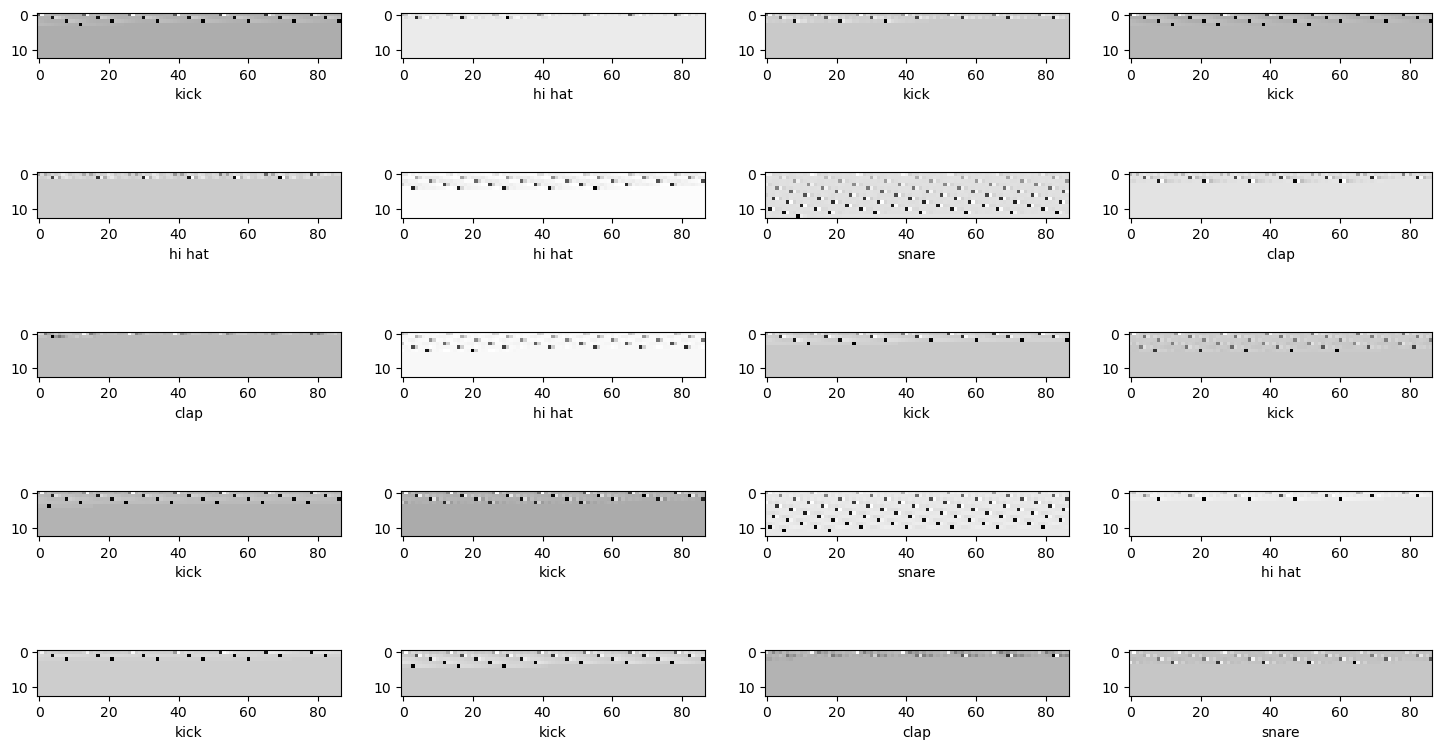

In [6]:
ind = np.random.permutation(X_train.shape[0])
plot_data(X_train, y_train, ind)

## 1. PCA

In [9]:
def eigsort(A):
    eigvals, U = np.linalg.eig(A)
    # sort eigenvalues in descending order
    order = np.argsort(eigvals)[::-1]
    eigvals = eigvals[order]
    #re-arrange the eigenvectors
    U = U[:,order]
    return U, eigvals

In [10]:
def pca(X, M):

    # get the mean of every column (feature) of matrix X
    mu = X.mean(axis=0).reshape((1,-1))

    # subtract the mean from X
    normalized_X = (X-mu)

    # calculate the Covariance matrix
    S = (1/X.shape[0]) * normalized_X.T.dot(normalized_X)

    # calcualte the eigenvectors and eigenvalues of the covariance matrix
    eigvectors, eigvals = eigsort(S)

    # Keep the first M columns of the eigenvectors
    U = eigvectors[:,:M]
    # Keep the first M values of the eigenvalues
    Lambdas = eigvals[:M]
    print( X.shape, U.shape, Lambdas.shape )

    # calculate Z = U * X
    Z = normalized_X.dot(U)
    return Z, U, Lambdas, mu

In [11]:
M = 50
# pca for train data
X_train_pca, eigvecs_train, eigvals_train, mu_train = pca(X_train, M)
X_train_rec = X_train_pca.dot(eigvecs_train.T) + mu_train
# pca for test data
X_test_pca, eigvecs_test, eigvals_test, mu_test = pca(X_test, M)
X_test_rec = X_test_pca.dot(eigvecs_test.T) + mu_test

(10172, 1131) (1131, 50) (50,)
(5014, 1131) (1131, 50) (50,)


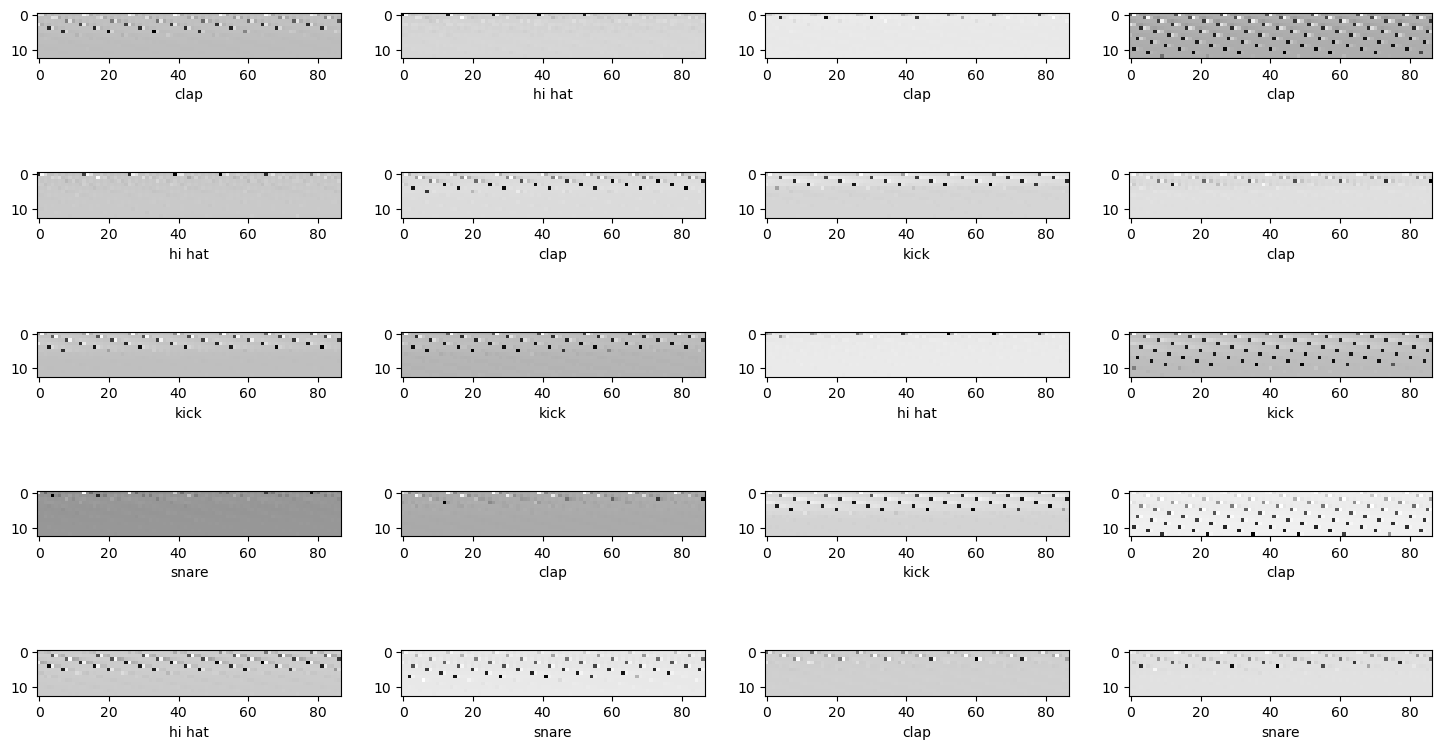

In [70]:
plot_data(X_train_rec, y_train, ind)

## 2. Least Squares

In [14]:
def computeCost(X, y, w): # for gradient descent
        return (1 / (2.0*X.shape[0])) * np.sum((( np.dot(X, w)-y)**2 ))
    
def gradient_descent(X, y, alpha=0.01, num_iters=1500):
    # create the error history
    J_history = np.zeros((num_iters, 1))
    # set W to all zeros
    w = np.zeros((X.shape[1], y.shape[1]))

    # number of data inputs
    m = X.shape[0]

    for iter in range(num_iters):
        print(f"Iterations: [{iter} / {num_iters}]")

        cost = computeCost(X, y, w)
        new_w = np.zeros_like(w)

        # for each feature calculate its new weight
        for j in range(len(new_w)):
            Suma = 0
            for i in range(m):
                Suma += (np.dot(w.T, X[i,:]) - y[i]) * X[i][j]
            new_w[j] = w[j] - (alpha / m) * Suma

        w = new_w

        # finished one iteration: add cost to history
        J_history[iter] = cost

    return (w, J_history)

In [15]:
class MyLinearRegression():
    def __init__(self, method=0, alpha=0.01, num_iters=1500):
        self.W = None
        self.predictions = None
        self.method = method # 0 -> Closed Form, 1 -> Gradient Descent

        # arguements for gradient descent
        self.alpha = alpha
        self.num_iters = num_iters

    def closed_form(self, X, y):
        XT_X = np.dot(X.T, X) # X^T * X
        inv_XT_X = np.linalg.inv(XT_X) # (X^T * X)^-1
        w = np.dot(np.dot(inv_XT_X, X.T), y) # theta = (X^T * X)^-1 * X^T * y
        return w

    def fit(self, X, y):
        X = np.hstack([np.ones((X.shape[0], 1)), X]) # add a column of 1s at the beginning
        if (self.method == 0): # closed form
            self.W = self.closed_form(X, y)
        elif (self.method == 1): # gradient descent
            self.W, self.error_history = gradient_descent(X, y, self.alpha, self.num_iters)
        #print("Shape of weights:", self.W.shape)

    def predict(self, X):
        X = np.hstack([np.ones((X.shape[0], 1)), X]) # add a column of 1s at the beginning
        self.predictions = np.dot(X, self.W)
        #print("Shape of predictions:", self.predictions.shape)

    def score(self, y):
        # extract predicted classes
        predicted_classes = np.argmax(self.predictions, axis=1)

        # measure accuracy
        true_labels = [np.where(onehot == 1)[0][0] for onehot in y]
        
        return np.mean(predicted_classes == true_labels)

### Testing our model

In [17]:
lin_reg = MyLinearRegression(method=0)
lin_reg.fit(X_train, y_train)

# test on train data
lin_reg.predict(X_train)
print("(Train) Accuracy:", lin_reg.score(y_train))

# test on test data
lin_reg.predict(X_test)
print("(Test) Accuracy:", lin_reg.score(y_test))

(Train) Accuracy: 0.8715100275265435
(Test) Accuracy: 0.8057439170323095


### Testing with sklearn

In [18]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

# predict train data
y_preds_train = lr.predict(X_train)
y_preds_train = np.argmax(y_preds_train, axis=1)
print("(Train) Accuracy:", np.mean(y_preds_train == np.argmax(y_train, axis=1)))

# predict test data
y_preds_test = lr.predict(X_test)
y_preds_test = np.argmax(y_preds_test, axis=1)
print("(Test) Accuracy:", np.mean(y_preds_test == np.argmax(y_test, axis=1)))

(Train) Accuracy: 0.8715100275265435
(Test) Accuracy: 0.8057439170323095


## 3. Logistic Regression

In [19]:
def cross_entropy(predicted, true):
    predicted = np.clip(predicted, 1e-15, 1 - 1e-15)
    suma = 0
    for i in range(true.shape[0]):
        for j in range(true.shape[1]):
            suma -= true[i][j] * np.log(predicted[i][j])
    suma /= true.shape[0]
    return suma

def grad_cross_entropy(X, predicted, true):
    return np.dot(X.T, (predicted - true))

# ax = 1 when array 2D, ax = 0 when array 1D
def softmax(X, ax=1):
    m = np.max(X, axis=ax, keepdims=True)
    p = np.exp(X - m)
    return (p / np.sum(p, axis=ax, keepdims=True))

In [20]:
class MyLogisticRegression():
    def __init__(self, alpha=0.01, num_iters=1500, tol=1e-7):
        self.W = None
        self.predictions = None

        # options
        self.alpha = alpha
        self.num_iters = num_iters
        self.tol = tol

    def fit(self, X, y):
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        self.W = np.zeros((X.shape[1], y.shape[1]))

        Lw_old = np.inf
        costs = []
        for i in range(1, self.num_iters + 1):
            # call softmax
            y_pred = softmax(np.dot(X, self.W))

            # call cross-entropy loss
            Lw = cross_entropy(y_pred, y)
            # add loss to costs array
            costs.append(Lw)

            # show the current cost function on screen
            if i % 50 == 0:
                print('Iteration : %d, Cost function :%f' % (i, Lw))

            # get the gradient of the loss function
            gradL = grad_cross_entropy(X, y_pred, y)

            # break if you achieve the desired accuracy in the cost function
            if np.abs(Lw - Lw_old) < self.tol:
                break

            Lw_old = Lw
            
            # do SGD
            self.W = self.W - self.alpha * gradL

        return (self.W, costs)
    
    def predict(self, X):
        X = np.hstack([np.ones((X.shape[0], 1)), X]) # add a column of 1s at the beginning
        self.predictions = np.dot(X, self.W)
        #print("Shape of predictions:", self.predictions.shape)

    def score(self, y):
        # extract predicted classes
        predicted_classes = np.argmax(self.predictions, axis=1)

        # measure accuracy
        true_labels = [np.where(onehot == 1)[0][0] for onehot in y]
        
        return np.mean(predicted_classes == true_labels)

### Testing our model

In [71]:
log_r = MyLogisticRegression(alpha=0.001)
weights, costs = log_r.fit(X_train_norm, y_train)

# test on train data
log_r.predict(X_train_norm)
print("\n(Train) Accuracy:", log_r.score(y_train))

# test on test data
log_r.predict(X_test_norm)
print("(Test) Accuracy:", log_r.score(y_test))

Iteration : 50, Cost function :7.110010
Iteration : 100, Cost function :8.188176
Iteration : 150, Cost function :6.393251
Iteration : 200, Cost function :4.877606
Iteration : 250, Cost function :6.728319
Iteration : 300, Cost function :5.496086
Iteration : 350, Cost function :8.203563
Iteration : 400, Cost function :5.712239
Iteration : 450, Cost function :5.421047
Iteration : 500, Cost function :5.750248
Iteration : 550, Cost function :6.411366
Iteration : 600, Cost function :6.357212
Iteration : 650, Cost function :6.598819
Iteration : 700, Cost function :5.241532
Iteration : 750, Cost function :5.651758
Iteration : 800, Cost function :5.420765
Iteration : 850, Cost function :6.819905
Iteration : 900, Cost function :4.448797
Iteration : 950, Cost function :5.286925
Iteration : 1000, Cost function :5.054476
Iteration : 1050, Cost function :6.111865
Iteration : 1100, Cost function :6.266488
Iteration : 1150, Cost function :4.913143
Iteration : 1200, Cost function :4.821755
Iteration : 

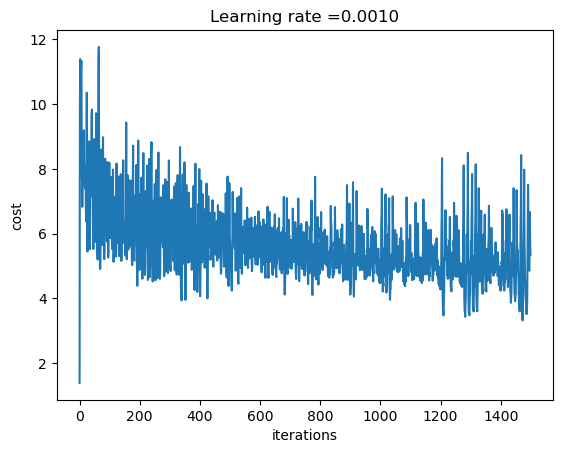

In [73]:
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate =" + str(format(1e-3, '.4f')))
plt.show()

### Testing with sklearn

In [24]:
from sklearn.linear_model import LogisticRegression

sk_log_r = LogisticRegression(max_iter=1500)
sk_log_r.fit(X_train_norm, y_train_labels)

# predict train data
y_preds_train = sk_log_r.predict(X_train_norm)
print("(Train) Accuracy:", np.mean(y_preds_train == y_train_labels))

# predict test data
y_preds_test = sk_log_r.predict(X_test_norm)
print("(Test) Accuracy:", np.mean(y_preds_test == y_test_labels))

(Train) Accuracy: 0.9245969327565867
(Test) Accuracy: 0.824890307140008


## 4. K-nn

In [25]:
def sqr_distance(x, y):
    y = np.tile(y,(x.shape[0], 1))
    d = np.sqrt((np.square(x-y).sum(axis=1)))
    return d

In [26]:
class kNN():
    def __init__(self, k=3):
        self.k = k

    def knn_test(self, X, y, X_test, k):
        # number of X_test data inputs
        m = X_test.shape[0]
        Ttest = np.zeros((m, y.shape[1]))

        for n in range(m):
            d = sqr_distance(X, X_test[n,:]) # get the distance between each test input with the X_train
            # return the indices of the k closest instances
            closest = np.argsort(d)[:k]
            Tclosest = y[closest]
            # get majority vote
            votes = Tclosest.sum(axis=0)
            Ttest[n, np.argmax(votes)] = 1

        return Ttest
    
    def cross_validation(self, K, numFolds, X, T):
        m = X.shape[0]
        # random permute the data before we split them
        np.random.seed(10)
        perm = np.random.permutation(m)
        X = X[perm]
        T = T[perm]

        chunk_size = int(m/numFolds)
        split_ind = np.arange(chunk_size, chunk_size * numFolds, chunk_size)

        Xfolds = np.vsplit(X, split_ind)
        Tfolds = np.vsplit(T, split_ind)
        val_err = np.zeros((K, numFolds))

        X_train = None
        T_train = None

        for k in range(1, K+1):
            for j in range(numFolds):
                X_train = np.vstack([Xfolds[i] for i in range(len(Xfolds)) if i != j])
                T_train = np.vstack([Tfolds[i] for i in range(len(Tfolds)) if i != j])
                X_test = Xfolds[j]

                # predictions using kNN
                Ttest = self.knn_test(X_train, T_train, X_test, k)
                # get the misclassified data points
                Tval = np.argmax(Ttest, axis=1)
                Tcorrect = np.argmax(Tfolds[j], axis=1)
                val_err[k-1, j] = np.count_nonzero(Tval != Tcorrect) / X_test.shape[0]
                print("kNN for k = {}, fold # {}, error = {} ".format(k, j, val_err[k-1, j]))

        # average the validation errors
        val = val_err.sum(axis=1) / numFolds
        # select best k
        k_best = np.argmin(val) + 1

        return (k_best, val)

### Testing our model

In [ ]:
# find best k
knn = kNN()
k_best, val = knn.cross_validation(10, 5, X_train_rec, y_train)
print(k_best)

kNN for k = 1, fold # 0, error = 0.23008849557522124 
kNN for k = 1, fold # 1, error = 0.22369714847590955 
kNN for k = 1, fold # 2, error = 0.2192723697148476 
kNN for k = 1, fold # 3, error = 0.21632251720747295 
kNN for k = 1, fold # 4, error = 0.2337917485265226 
kNN for k = 2, fold # 0, error = 0.252212389380531 
kNN for k = 2, fold # 1, error = 0.24287118977384464 
kNN for k = 2, fold # 2, error = 0.2374631268436578 
kNN for k = 2, fold # 3, error = 0.22812192723697147 
kNN for k = 2, fold # 4, error = 0.23722986247544203 
kNN for k = 3, fold # 0, error = 0.23008849557522124 
kNN for k = 3, fold # 1, error = 0.21337266470009833 
kNN for k = 3, fold # 2, error = 0.22713864306784662 
kNN for k = 3, fold # 3, error = 0.21337266470009833 
kNN for k = 3, fold # 4, error = 0.2180746561886051 
kNN for k = 4, fold # 0, error = 0.22123893805309736 
kNN for k = 4, fold # 1, error = 0.22123893805309736 
kNN for k = 4, fold # 2, error = 0.2079646017699115 
kNN for k = 4, fold # 3, error = 0.

In [26]:
Ttest = knn.knn_test(X_train_rec, y_train, X_test_rec, 4)
print("Test data complete.")
Ttrain = knn.knn_test(X_train_rec, y_train, X_train_rec, 4)
print("Train data complete.")

Test data complete.
Train data complete.


In [27]:
# test train data
Tval_train = np.argmax(Ttrain, axis=1)
Tcor_train = np.argmax(y_train, axis=1)

# test test data
Tval_test = np.argmax(Ttest, axis=1)
Tcor_test = np.argmax(y_test, axis=1)

print("(Train) Accuracy:", np.mean(Tval_train == Tcor_train))
print("(Test) Accuracy:", np.mean(Tval_test == Tcor_test))

(Train) Accuracy: 0.8661030279197798
(Test) Accuracy: 0.7919824491424012


### Testing with sklearn

In [43]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3) # 3 better than 4 here
neigh.fit(X_train_rec, y_train)

# test on train data
neigh_preds_train = neigh.predict(X_train_rec)
print("(Train) Accuracy:", neigh.score(X_train_rec, y_train))

# test on test data
neigh_preds_test = neigh.predict(X_test_rec)
print("(Test) Accuracy:", neigh.score(X_test_rec, y_test))

(Train) Accuracy: 0.8680692095949666
(Test) Accuracy: 0.7766254487435181


## 5. Naive Bayes

In [58]:
class MyNaiveBayes():
    def __init__(self):
        self.classes = None
        self.p_y = []
        self.means = []
        self.covariances = []

    def gaussian_likelihood(self, x, mean_k, cov_k):
        d = x.shape[1] # number of features
        cov_k_determ = np.linalg.det(cov_k) # get the determinant of the covariance matrix for class k

        coeff = 1 / np.sqrt(2 * np.pi * cov_k_determ)
        exponent = np.exp(-0.5 * np.dot(((x - mean_k) ** 2), np.linalg.inv(cov_k)))
        return coeff * exponent

    def fit(self, X, y):
        self.classes = np.unique(y)

        for c in self.classes:
            X_c = X[y == c] # get all the samples of class c
            self.p_y.append(X_c.shape[0] / X.shape[0]) # get the probability p(y=c)
            self.means.append(np.mean(X_c, axis=0)) # get the mean of each feature from the sampels of class c
            cov = np.cov(X_c, rowvar=False)
            cov[cov == 0] = 1e-6
            self.covariances.append(cov) # get the covariance of the array X_c

        self.p_y =  np.array(self.p_y)
        self.means = np.array(self.means)
        self.covariances = np.array(self.covariances)

    def predict_proba(self, X):
        probs = np.zeros((X.shape[0], len(self.classes)))

        for k in range(len(self.classes)):
            mean_k = self.means[k]
            cov_k = self.covariances[k]
            p_yk = self.p_y[k]

            likelihood = self.gaussian_likelihood(X, mean_k, cov_k)
            total_likelihood = np.prod(likelihood, axis=1)
            probs[:, k] = p_yk * total_likelihood

        probs /= probs.sum(axis=1, keepdims=True)

        return probs
    
    def predict(self, X):
        probs = self.predict_proba(X)
        return self.classes[np.argmax(probs, axis=1)]

### Testing our data

In [59]:
naive_bayes = MyNaiveBayes()

naive_bayes.fit(X_train, y_train_labels)

naive_preds_train = naive_bayes.predict(X_train)
print("(Train) Accuracy:", np.mean(naive_preds_train == y_train_labels))

naive_preds_test = naive_bayes.predict(X_test)
print("(Test) Accuracy:", np.mean(naive_preds_test == y_test_labels))

C:\Users\georg\AppData\Local\Temp\ipykernel_20320\382567751.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  coeff = 1 / np.sqrt(2 * np.pi * cov_k_determ)
C:\Users\georg\AppData\Local\Temp\ipykernel_20320\382567751.py:13: RuntimeWarning: overflow encountered in exp
  exponent = np.exp(-0.5 * np.dot(((x - mean_k) ** 2), np.linalg.inv(cov_k)))
C:\Users\georg\AppData\Local\Temp\ipykernel_20320\382567751.py:14: RuntimeWarning: invalid value encountered in multiply
  return coeff * exponent


(Train) Accuracy: 0.11570979158474243
(Test) Accuracy: 0.11587554846429995


### Testing with sklearn

In [60]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train_labels)

# test on train data
nb_preds_train = nb.predict(X_train)
print("(Train) Accuracy:", np.mean(nb_preds_train == y_train_labels))

# test on test data
nb_preds_test = nb.predict(X_test)
print("(Test) Accuracy:", np.mean(nb_preds_test == y_test_labels))

(Train) Accuracy: 0.49488792764451434
(Test) Accuracy: 0.48484244116473874


## 6. Perceptron

In [48]:
import torch
from torch import nn
from torch import optim

class MyMLP(nn.Module):
    def __init__(self, n_features, n_hidden, num_classes):
        super().__init__()
        # Linear layers
        self.fc1 = nn.Linear(n_features, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, num_classes)

    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        y = self.fc3(x)
        return y

In [74]:
input_size = X_train.shape[1]
hidden_size = 512
output_size = y_train.shape[1]

mlp = MyMLP(input_size, hidden_size, output_size)

In [75]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

In [76]:
num_epochs = 500
batch_size = 64

for epoch in range(num_epochs):
    # get data in batches
    for i in range(0, X_train.shape[0], batch_size):
        # get batch
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        # convert batch to tensor
        X_batch = torch.tensor(X_batch, dtype=torch.float32)
        y_batch = torch.tensor(y_batch, dtype=torch.float32)

        # forward pass
        outputs = mlp.forward(X_batch)
        loss = loss_function(outputs, y_batch)

        # backwards pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')


Epoch 1/500, Loss: 0.0001
Epoch 2/500, Loss: 0.0002
Epoch 3/500, Loss: 0.0000
Epoch 4/500, Loss: 0.0000
Epoch 5/500, Loss: 0.0000
Epoch 6/500, Loss: 0.0000
Epoch 7/500, Loss: 0.0000
Epoch 8/500, Loss: 0.0002
Epoch 9/500, Loss: 0.0001
Epoch 10/500, Loss: 0.0019
Epoch 11/500, Loss: 0.0496
Epoch 12/500, Loss: 0.1350
Epoch 13/500, Loss: 0.0888
Epoch 14/500, Loss: 0.3613
Epoch 15/500, Loss: 0.2473
Epoch 16/500, Loss: 0.0937
Epoch 17/500, Loss: 0.0164
Epoch 18/500, Loss: 0.0039
Epoch 19/500, Loss: 0.0015
Epoch 20/500, Loss: 0.0038
Epoch 21/500, Loss: 0.0402
Epoch 22/500, Loss: 0.0003
Epoch 23/500, Loss: 0.0013
Epoch 24/500, Loss: 0.0415
Epoch 25/500, Loss: 0.9694
Epoch 26/500, Loss: 0.9890
Epoch 27/500, Loss: 0.9145
Epoch 28/500, Loss: 0.9127
Epoch 29/500, Loss: 0.8322
Epoch 30/500, Loss: 0.0020
Epoch 31/500, Loss: 0.0006
Epoch 32/500, Loss: 0.0005
Epoch 33/500, Loss: 0.0000
Epoch 34/500, Loss: 0.0111
Epoch 35/500, Loss: 0.0001
Epoch 36/500, Loss: 0.1897
Epoch 37/500, Loss: 0.2211
Epoch 38/5

In [77]:
mlp.eval()

with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    outputs_test = mlp.forward(X_test_tensor)
    _, preds_test = torch.max(outputs_test, 1)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    outputs_train = mlp.forward(X_train_tensor)
    _, preds_train = torch.max(outputs_train, 1)

# test on train data
correct_train = 0
for i in range(len(preds_train)):
    if (preds_train[i] == y_train_labels[i]):
        correct_train += 1

# test on test data
correct_test = 0
for i in range(len(preds_test)):
    if (preds_test[i] == y_test_labels[i]):
        correct_test += 1

print("(Train) Accuracy:", correct_train / len(y_train_labels))
print("(Test) Accuracy:", correct_test / len(y_test_labels))

(Train) Accuracy: 0.8997247345654739
(Test) Accuracy: 0.8075388911049063


## 7. SVM

In [27]:
def hinge_error(X, y, w, b, lambda_param):
    n = X.shape[0]
    
    # regularization term
    regularization_term = lambda_param * np.dot(w, w)
    
    # sum
    margins = y * (np.dot(X, w) - b)
    hinge_loss = np.maximum(0, 1 - margins)
    suma = np.sum(hinge_loss)
    suma /= n
    
    return regularization_term + suma

In [32]:
class MySVM():
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000, tol=1e-7):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.tol = tol
        self.W = None
        self.b = None
        self.J_history = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        n_classes = y.shape[1]

        self.J_history = np.zeros((n_classes, self.n_iters))

        # initialize weights
        self.W = np.zeros((n_classes, n_features))
        self.b = np.zeros(n_classes)
        
        for c in range(n_classes):
            y_c = np.where(np.argmax(y, axis=1) == c, 1, -1)

            # initialize weights for positive class
            w = np.zeros(n_features)
            b = 0

            # update
            J_old = np.inf
            for i in range(self.n_iters):
                condition = y_c * (np.dot(X, w) - b) >= 1
                misclassified = [False if con else True for con in condition]

                # error
                J = hinge_error(X, y_c, w, b, self.lambda_param)
                self.J_history[c][i] = J

                # use boolean masks to compute the gradients instead of iterating
                grad_w = -np.dot(X[misclassified].T, y_c[misclassified]) / n_samples
                grad_b = -np.sum(y_c[misclassified]) / n_samples

                # update weights and bias with regularization
                w -= self.learning_rate * (grad_w + 2 * self.lambda_param * w)
                b -= self.learning_rate * grad_b

                if np.abs(J - J_old) < self.tol and i > self.n_iters / 2: # break if error had close to 0 change
                    print("Ending on " + str(c) + ".Iter" + str(i) + "because error difference from last iteration is" + str(abs(J - J_old)))
                    break

                if (i % 100 == 0): print(str(c) + ".Iter" + str(i) + " Current Error: " + str(J) + " Error Dif: " + str(abs(J - J_old)))
                
                J_old = J

            # add weights of positive class
            self.W[c] = w
            self.b[c] = b

    def predict(self, X):
        scores = np.dot(X, self.W.T) + self.b.T

        # choose the class with the highest score for each sample
        predictions = np.argmax(scores, axis=1)
        return predictions

### Testing our model

In [56]:
mySVM = MySVM(lambda_param=0.01, learning_rate=1e-4, n_iters=3000)
mySVM.fit(X_train_norm, y_train)
print('Train complete')

0.Iter0 Current Error: 1.0 Error Dif: inf
0.Iter100 Current Error: 0.9340652010325199 Error Dif: 0.0005089378447089565
0.Iter200 Current Error: 0.8978701096160332 Error Dif: 0.0002325206480968678
0.Iter300 Current Error: 0.8810112593438673 Error Dif: 0.00011644421510426106
0.Iter400 Current Error: 0.871943124817842 Error Dif: 6.792138594180486e-05
0.Iter500 Current Error: 0.8668364642391808 Error Dif: 3.711363914549182e-05
0.Iter600 Current Error: 0.8641331311841963 Error Dif: 1.717784211063833e-05
0.Iter700 Current Error: 0.8631029424218458 Error Dif: 3.2683546157263876e-06
0.Iter800 Current Error: 0.8633241641647602 Error Dif: 7.232194057626984e-06
0.Iter900 Current Error: 0.8644232659992853 Error Dif: 1.46683100751277e-05
0.Iter1000 Current Error: 0.8661527297603505 Error Dif: 1.986147569055241e-05
0.Iter1100 Current Error: 0.8683450817176159 Error Dif: 2.3881625540567164e-05
0.Iter1200 Current Error: 0.8709869443250259 Error Dif: 2.8081551043834807e-05
0.Iter1300 Current Error: 0.8

In [57]:
# test on train data
preds_train = mySVM.predict(X_train_norm)

# test on test data
preds_test = mySVM.predict(X_test_norm)

print("(Train) Accuracy:", np.mean(preds_train == y_train_labels))
print("(Test) Accuracy:", np.mean(preds_test == y_test_labels))

(Train) Accuracy: 0.7853912701533622
(Test) Accuracy: 0.789589150378939


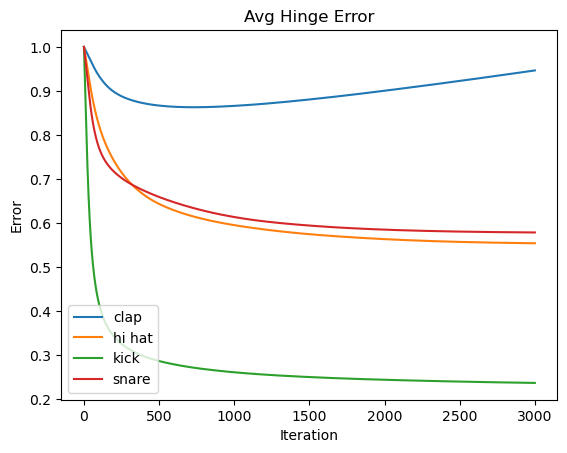

In [58]:
# plot errors for each class
plt.title("Avg Hinge Error")
plt.ylabel("Error")
plt.xlabel("Iteration")
for idx, name in enumerate(sound_X_names):
    plt.plot(np.squeeze(mySVM.J_history[idx]), label=name)
    plt.legend()

plt.show()

### Testing with sklearn

In [59]:
from sklearn import svm

sk_svm = svm.SVC()
sk_svm.fit(X_train_norm, y_train_labels)

# test on train data
sk_preds_train = sk_svm.predict(X_train_norm)

# test on test data
sk_preds_test = sk_svm.predict(X_test_norm)

print("(Train) Accuracy:", np.mean(sk_preds_train == y_train_labels))
print("(Test) Accuracy:", np.mean(sk_preds_test == y_test_labels))

(Train) Accuracy: 0.9058198977585529
(Test) Accuracy: 0.8603909054646989


## 8. K-Means

In [7]:
# euclidean distance
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum(x1 - x2) ** 2)

In [60]:
class KMeans():
    def __init__(self, K=4, max_iters=100):
        self.K = K
        self.max_iters = max_iters

        self.clusters = [[] for _ in range(self.K)]
        self.centroids = []

    def predict(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape

        # initialize centroids
        random_sample_indxs = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroids = [self.X[idx] for idx in random_sample_indxs]

        # optimize clusters
        for i in range(self.max_iters):
            # assign samples to closest centroid
            self.clusters = self._create_clusters(self.centroids)

            # calculate new centroids from the clusters
            centroids_old = self.centroids
            self.centroids = self._get_centroids(self.clusters)

            # if converges then stop
            if self._is_converged(centroids_old, self.centroids):
                break

            if (i % 50 == 0):
                print("Iteration", i)

        # classify samples
        return self._get_cluster_labels(self.clusters)

    def _create_clusters(self, centroids):
        clusters = [[] for _ in range(self.K)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self._closest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)

        return clusters

    def _closest_centroid(self, sample, centroids):
        # distance of the current sample to each centroid
        distances = [euclidean_distance(sample, point) for point in centroids]
        # get the point with the closest distance
        closest_idx = np.argmin(distances)
        
        return closest_idx

    def _get_centroids(self, clusters):
        # assign mean value of the clusters to the centroids
        centroids = np.zeros((self.K, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean

        return centroids

    def _is_converged(self, old, new):
        # check distances between old and new centroids
        distances = [euclidean_distance(old[i], new[i]) for i in range(self.K)]
        return sum(distances) == 0

    def _get_cluster_labels(self, clusters):
        labels = np.empty(self.n_samples)
        for cluster_idx, cluster in enumerate(clusters):
            for sample_idx in cluster:
                labels[sample_idx] = cluster_idx

        return labels
    
    def accuracy_score(self, y_true, y_pred):

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        mapped_labels = np.zeros_like(y_pred)

        # for each cluster
        for cluster in range(self.K):
            mask = (y_pred == cluster) # find the indices of the current cluster in the predictions

            label_counts = {}
            for true_label in y_true[mask]:
                if true_label in label_counts:
                    label_counts[true_label] += 1
                else:
                    label_counts[true_label] = 1

            # find the most common true label
            if label_counts:
                true_label = max(label_counts, key=label_counts.get)
                mapped_labels[mask] = true_label

        accuracy = np.mean(mapped_labels == y_true)
        return accuracy

            

In [65]:
k_means = KMeans(K=4, max_iters=100)

X_total = np.concatenate((X_train, X_test))
y_total = np.concatenate((y_train, y_test))
y_total_labels = [np.argmax(onehot) for onehot in y_total]

k_means_res = k_means.predict(X_total)


Iteration 0
Iteration 50


In [66]:
k_means_accuracy = k_means.accuracy_score(y_total_labels, k_means_res)
print("Accuracy:", k_means_accuracy)

Accuracy: 0.45509021467140787
